In [60]:
#2D Rayleigh-Bernard convection in Boussineq approximation

#Importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import dedalus.public as de
from dedalus.extras import flow_tools
from dedalus.tools import post
import shutil
import random
import time
import h5py
import pathlib
import logging

logger = logging.getLogger('2D RB Convection')

In [61]:
#Defining variables
Lx, d = (5. ,1. )
xres, zres = (128, 64) #Change these to change resolution

#Non-dimensional numbers
Pr = 5
Ra = 1.4e5

In [62]:
#Defining basis and domains
xbasis = de.Fourier('x',xres,interval=(0,Lx),dealias=3/2)
zbasis = de.Chebyshev('z',zres,interval=(0,d),dealias=3/2)

domain = de.Domain([xbasis,zbasis],grid_dtype=np.float64)
problem = de.IVP(domain,variables=['T','p','u','w','Tz','uz','wz'])

In [63]:
#Defining non-dimensional parameters
problem.parameters['Pr'] = Pr
problem.parameters['Ra'] = Ra
problem.parameters['xres'] = xres

#Main Boussineq Rayleigh-Bernard convection equations
problem.add_equation("dt(u) + dx(p) - (dx(dx(u)) + dz(uz)) = - (u * dx(u) + w * uz)")
problem.add_equation("dt(w) + dz(p) - (dx(dx(w)) + dz(wz)) - (Ra / Pr) * T = - (u * dx(w) + w * wz)")
problem.add_equation("dt(T) - (1 / Pr) * (dx(dx(T)) + dz(Tz)) = - (u * dx(T) + w * Tz)")

#Auxillary equations
problem.add_equation("dz(u) - uz = 0")
problem.add_equation("dz(w) - wz = 0")
problem.add_equation("dz(T) - Tz = 0")

#Continuity equation
problem.add_equation("dx(u) + wz = 0")

#Boundary conditions

#Fixed temperature at top boundary
problem.add_bc("right(T) = 0")

#Fixed flux on bottom boundary
problem.add_bc("left(Tz) = -1")

#Standard fluid dynamics boundary conditions
problem.add_bc("left(u) = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("left(w) = 0")
problem.add_bc("right(w) = 0",condition="(nx != 0)")
problem.add_bc("right(p) = 0",condition="(nx == 0)")

In [64]:
#Build solver
solver = problem.build_solver(de.timesteppers.RK111) #RK111 = first order runge kutte timestepping method
logger.info('Solver built')

2021-02-28 20:50:27,183 pencil 0/1 INFO :: Building pencil matrix 1/64 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 2.5e+01/s
2021-02-28 20:50:27,278 pencil 0/1 INFO :: Building pencil matrix 7/64 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.2e+01/s
2021-02-28 20:50:27,399 pencil 0/1 INFO :: Building pencil matrix 14/64 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 5.4e+01/s
2021-02-28 20:50:27,545 pencil 0/1 INFO :: Building pencil matrix 21/64 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 5.2e+01/s
2021-02-28 20:50:27,654 pencil 0/1 INFO :: Building pencil matrix 28/64 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 5.5e+01/s
2021-02-28 20:50:27,764 pencil 0/1 INFO :: Building pencil matrix 35/64 (~55%) Elapsed: 1s, Remaining: 1s, Rate: 5.6e+01/s
2021-02-28 20:50:27,879 pencil 0/1 INFO :: Building pencil matrix 42/64 (~66%) Elapsed: 1s, Remaining: 0s, Rate: 5.7e+01/s
2021-02-28 20:50:27,986 pencil 0/1 INFO :: Building pencil matrix 49/64 (~77%) Elapsed: 1s, Remaining: 0s, Rate: 5.8e+01/s
2021-02-28 20:50:28

In [65]:
#Initial conditions or restart
if not pathlib.Path('restart.h5').exists():

    #Initial conditions
    x, z = domain.all_grids()
    T = solver.state['T']
    Tz = solver.state['Tz']

    #Creating random perturbations
    gshape = domain.dist.grid_layout.global_shape(scales=1)
    slices = domain.dist.grid_layout.slices(scales=1)
    rand = np.random.RandomState(seed=42)
    noise = rand.standard_normal(gshape)[slices]

    #Linear background + perturbations damped at walls
    zb,zt = zbasis.interval
    pert = 1e-1 * noise * (zt - z) * (z - zb)
    T['g'] = pert
    T.differentiate('z',out=Tz)

    #Timestepping and output
    dt = 1e-5
    stop_sim_time = 5 #Change this to change total sim time
    fh_mode = 'overwrite'

else:
    #Restart
    write,last_dt = solver.load_state('restart.h5', -1)

    #Timestepping and output
    dt = last_dt
    stop_sim_time = 5e-3
    fh_mode = 'append'

In [66]:
#Integration parameters
solver.stop_sim_time = stop_sim_time
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

In [67]:
#Analysis
shutil.rmtree('snapshots', ignore_errors=True)
snapshots = solver.evaluator.add_file_handler('snapshots',sim_dt=1e-3,max_writes=200,mode=fh_mode)
snapshots.add_task("integ(T,'x')/xres", layout='g', name='<Tx>')
snapshots.add_task("0.5 * (u ** 2 + w ** 2)", layout='g', name='KE')
snapshots.add_task("sqrt(u ** 2 + w ** 2)", layout='g', name='|uvec|')
snapshots.add_system(solver.state)

In [68]:
#CFL (don't touch)
CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=10, safety=0.5, max_change=1.5, min_change=1, max_dt=1e-3, threshold=0.05)
CFL.add_velocities(('u', 'w'))

flow = flow_tools.GlobalFlowProperty(solver, cadence=10)
flow.add_property("sqrt(u ** 2 + w ** 2)/Ra", name='Re')

In [69]:
# Main loop 
try:
    logger.info('Starting loop')
    start_time = time.time()
    while solver.proceed:
        dt = CFL.compute_dt()
        dt = solver.step(dt)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f minutes' %((end_time-start_time)/60))

: 3271, Time: 3.175759e+00, dt: 1.000000e-03
2021-02-28 20:52:14,525 
2D RB Convection 0/1 INFO :: Iteration: 3281, Time: 3.185759e+00, dt: 1.000000e-03
2021-02-28 20:52:14,837 
2D RB Convection 0/1 INFO :: Iteration: 3291, Time: 3.195759e+00, dt: 1.000000e-03
2021-02-28 20:52:15,218 
2D RB Convection 0/1 INFO :: Iteration: 3301, Time: 3.205759e+00, dt: 1.000000e-03
2021-02-28 20:52:15,552 
2D RB Convection 0/1 INFO :: Iteration: 3311, Time: 3.215759e+00, dt: 1.000000e-03
2021-02-28 20:52:15,856 
2D RB Convection 0/1 INFO :: Iteration: 3321, Time: 3.225759e+00, dt: 1.000000e-03
2021-02-28 20:52:16,166 
2D RB Convection 0/1 INFO :: Iteration: 3331, Time: 3.235759e+00, dt: 1.000000e-03
2021-02-28 20:52:16,638 
2D RB Convection 0/1 INFO :: Iteration: 3341, Time: 3.245759e+00, dt: 1.000000e-03
2021-02-28 20:52:16,962 
2D RB Convection 0/1 INFO :: Iteration: 3351, Time: 3.255759e+00, dt: 1.000000e-03
2021-02-28 20:52:17,268 
2D RB Convection 0/1 INFO :: Iteration: 3361, Time: 3.265759e+00, 

In [70]:
#Merging analysis files
post.merge_process_files("snapshots", cleanup=True)
set_paths = list(pathlib.Path("snapshots").glob("snapshots_s*.h5"))
post.merge_sets("snapshots/snapshots.h5", set_paths, cleanup=True)

2021-02-28 20:53:22,980 post 0/1 INFO :: Merging files from snapshots
2021-02-28 20:55:05,371 post 0/1 INFO :: Creating joint file snapshots/snapshots.h5


In [ ]:
#Analysis 1 
#Convection plotting using temperature 
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    T = file['tasks']['T']
    t = T.dims[0]['sim_time']
    x = T.dims[1][0]
    z = T.dims[2][0]

    def animate(frame):
        quad.set_array(frame.T)

    #Plot data
    fig = plt.figure(figsize=(7, 6), dpi=100)
    quad = plt.pcolormesh(x, z, T[0].T, shading='nearest', cmap='coolwarm',vmin=0,vmax=1e-1)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.tight_layout()

    #Animation
    animation = ani.FuncAnimation(fig, animate, frames=T[:])
    animation.save('convection.gif',fps=200)



6


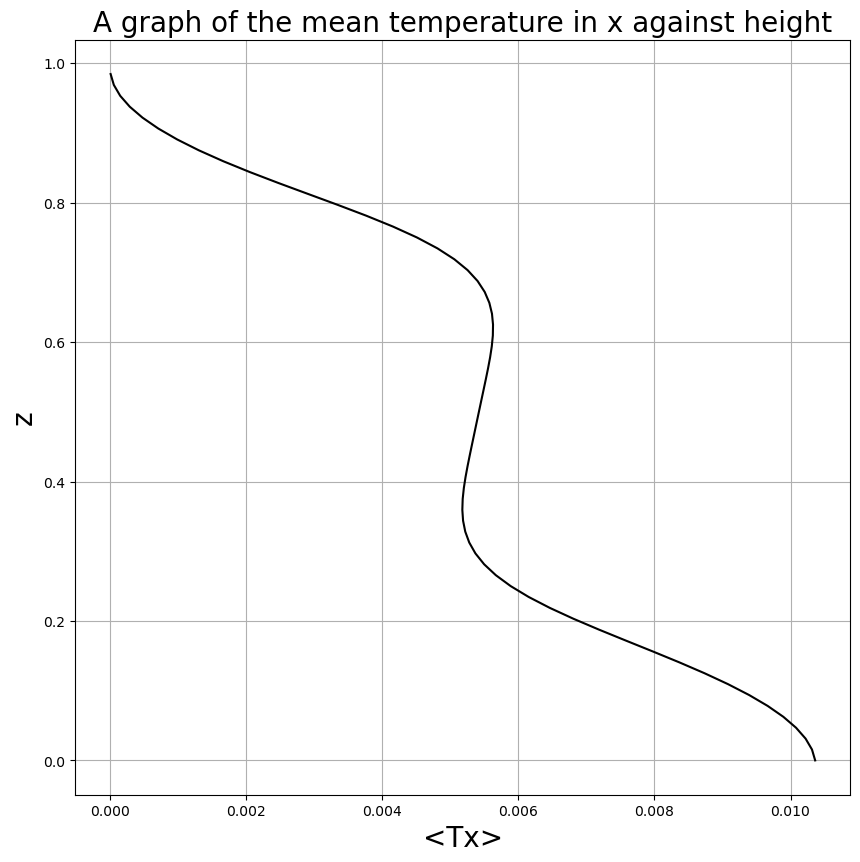

In [73]:
#Analysis 2
#Plotting average temperature as a function of height
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    #Load analysis datasets:
    Tx = file['tasks']['<Tx>']
    z = np.arange(0.,d,1/zres)
    t = Tx.dims[0]

    #Plot data
    fig = plt.figure(figsize=(10,10), dpi=100)
    quad = plt.plot(Tx[-1][0][:],z,'black')
    plt.title('A graph of the mean temperature in x against height',fontsize=20)
    plt.grid()
    plt.xlabel('<Tx>',fontsize=20)
    plt.ylabel('z',fontsize=20)
    plt.savefig("meantemp.jpeg")

In [ ]:
#Analysis 3
#Convection plotting using kinetic energy
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    KE = file['tasks']['KE']
    t = KE.dims[0]['sim_time']
    x =KE.dims[1][0]
    z = KE.dims[2][0]

    KEmax = np.max(KE[:][:][:])

    def animate(frame):
        quad.set_array(frame.T)

    #Plot data
    fig = plt.figure(figsize=(10, 10), dpi=100)
    quad = plt.pcolormesh(x, z, KE[0].T, shading='nearest', cmap='inferno',vmin = 0,vmax=0. 95 * KEmax)
    plt.colorbar(label='Kinetic Energy')
    plt.title('A graph showing the kinetic energy of \na fluid in Rayleigh-Bernard convection through time')
    plt.xlabel('x', fontsize=20)
    plt.ylabel('z', fontsize=20)
    plt.tight_layout()

    #Animation
    animation = ani.FuncAnimation(fig, animate, frames=KE[:])
    animation.save('KEconvection.gif',fps=200)

In [ ]:
#Analysis 4
#Convection plotting using momentum
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    uvec = file['tasks']['|uvec|']
    t = uvec.dims[0]['sim_time']
    x =uvec.dims[1][0]
    z = uvec.dims[2][0]

    uvecmax = np.max(uvec[:][:][:])

    def animate(frame):
        quad.set_array(frame.T)

    #Plot data
    fig = plt.figure(figsize=(10, 10), dpi=100)
    quad = plt.pcolormesh(x, z, uvec[0].T, shading='nearest', cmap='inferno', vmin = 0, vmax= 0.95 * uvecmax)
    plt.colorbar(label='|u|')
    plt.title(' ')
    plt.xlabel('x', fontsize=20)
    plt.ylabel('z', fontsize=20)
    plt.tight_layout()

    #Animation
    animation = ani.FuncAnimation(fig, animate, frames=uvec[:])
    animation.save('uvec_convection.gif',fps=200)